#### This notebook analyses the effects of adding in a season cycle (sinusoid with 1 yr period) in the 1D model.

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean as cm

## The model

Consider the following modification to the heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0(t))\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

_Make a note of the initial and boundary conditions._

We will write a forward-time, central-space finite difference scheme for this initial-boundary value problem. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [2]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell


# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)


# # Initial condition: replicating the globally-averaged annually-averaged profile in the ACCESS control simulation. Sliced between 66.5 S and 66.5 N.
# # cf. notebook: ACCESS_temperature_profile.ipynb

# T_access = np.array([18.72962875, 18.71776308, 18.69791137, 18.65953715, 18.59233366,
#         18.4877693 , 18.32777701, 18.10955722, 17.83265471, 17.50359963,
#         17.12776242, 16.69579974, 16.17275077, 15.51015988, 14.64561039,
#         13.68938628, 12.81617282, 12.06698519, 11.35341532, 10.651462  ,
#          9.91621954,  9.17371283,  8.47307245,  7.79774866,  7.11181125,
#          6.39582611,  5.69181462,  5.00613208,  4.34195891])
# z_access = np.array([1.15174985,    3.64867401,    6.56491852,    9.97086906,
#           13.94870853,   18.59437943,   24.01987267,   30.35588455,
#           37.75489044,   46.39470291,   56.48257065,   68.25986481,
#           82.00740814,   98.0514679 ,  116.7703476 ,  138.60160828,
#          164.04943848,  193.69206238,  228.18814087,  268.28121948,
#          314.8001709 ,  368.65353394,  430.81393433,  502.28930664,
#          584.0770874 ,  677.10028076,  782.12670898,  899.6817627 ,
#         1029.96813965])

# def linear_interpol(T_old, z_old, z_new):
#     T_new = np.full_like(z_t, 0)
    
#     j = 0
#     for i in range(len(z_new)):
#         if z_new[i] < z_old[j + 1]:
#             T_new[i] = T_old[j] + (T_old[j + 1] - T_old[j]) / (z_old[j + 1] - z_old[j]) * (z_new[i] - z_old[j])
#         else:
#             j += 1
#             T_new[i] = T_old[j] + (T_old[j + 1] - T_old[j]) / (z_old[j + 1] - z_old[j]) * (z_new[i] - z_old[j])
#     return T_new

# T_i = linear_interpol(T_access, z_access, z_t)

# plt.figure(figsize=(11,11))
# plt.plot(linear_interpol(T_access, z_access, z_t), z_t, label='ACCESS control')
# plt.plot(initial_condition(z_t), z_t, label='Linear stratification')
# plt.title('Globally-averaged, annually-averaged temperature profile between 66.5 S and 66.5 N in ACCESS-OM2 control vs. linear stratification')
# plt.xlabel('Temperature (deg C)')
# plt.ylabel('Depth (m)')
# plt.gca().invert_yaxis()
# plt.legend()

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (ie, need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        #OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = np.mean(T[:, i]) # This is for average temperature
        
    return OHC 




### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

In [3]:
def average_over_period(T_anom, period):
    num_periods = int(years / period)
    
    means = np.array([np.mean(T_anom[period * i * 36 : period * (i + 1) * 36]) for i in range(num_periods)]) # the averages over the window of length = period
    times = np.array([(period * i * 36 + 0.5 * period * 36) for i in range(num_periods)]) # the half-period times
    
    return means, times

In [4]:
def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)

Q = 8.0
T0 = 1.0

In [26]:
years = 5000
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

period = 1
Q_season_SH = 32 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
T0_season_SH = 4 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
Q_season_NH = 32 * np.sin((2 * np.pi / (period * 360)) * t)
T0_season_NH = 4 * np.sin((2 * np.pi / (period * 360)) * t)

control_with_seasonal_NH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_season_NH, T0_season_NH, years)
control_with_seasonal_SH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_season_SH, T0_season_SH, years)

In [6]:
control_with_seasonal_NH_periodic_ave = average_over_period(OHC(control_with_seasonal_NH), 1)
control_with_seasonal_SH_periodic_ave = average_over_period(OHC(control_with_seasonal_SH), 1)

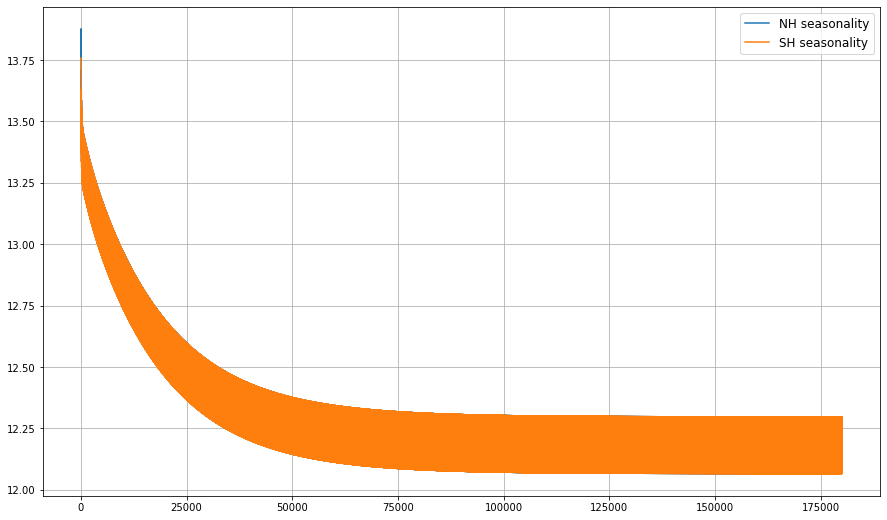

In [7]:
plt.figure(figsize=(15,9))
plt.plot(OHC(control_with_seasonal_NH),label='NH seasonality')
plt.plot(OHC(control_with_seasonal_SH),label='SH seasonality')
plt.grid()
plt.legend(fontsize=12)

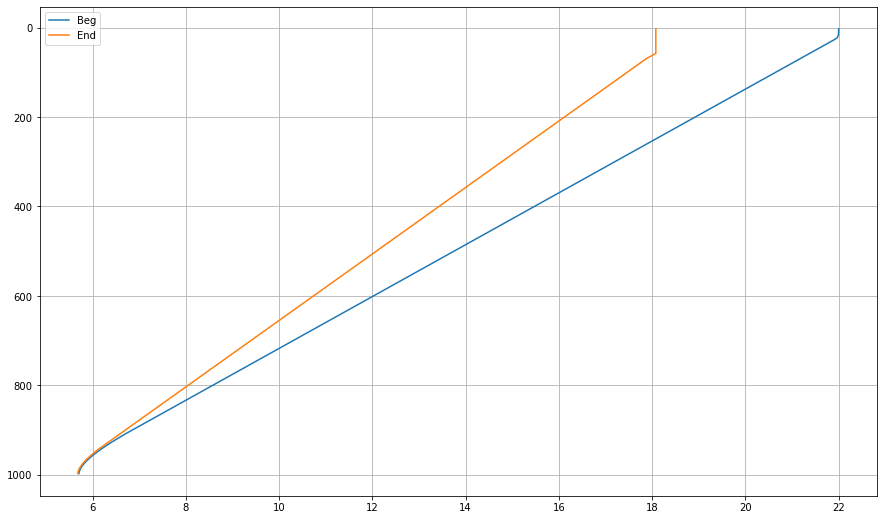

In [12]:
plt.figure(figsize=(15,9))
plt.plot(control_with_seasonal_NH[:,0], z_t,label='Beg')
plt.plot(control_with_seasonal_NH[:,-6], z_t,label='End')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

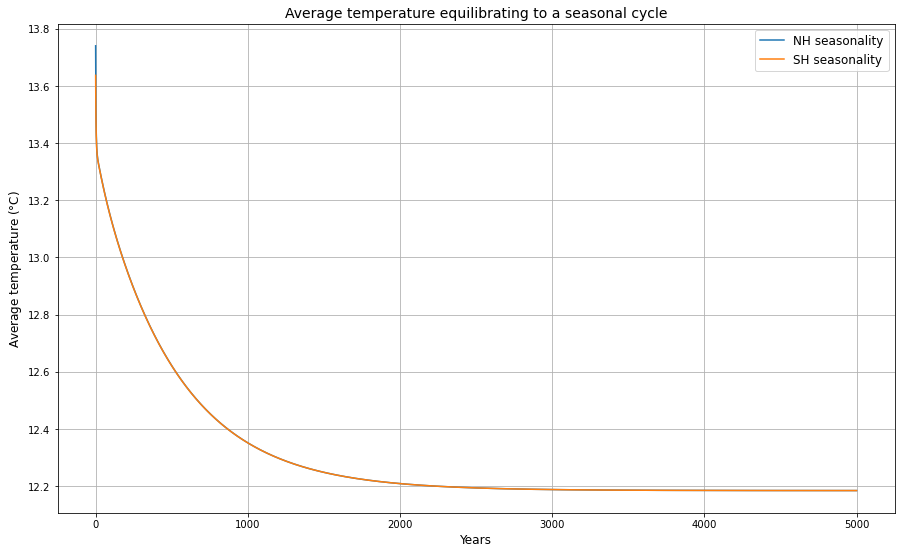

In [13]:
plt.figure(figsize=(15,9))
plt.plot(control_with_seasonal_NH_periodic_ave[1]/36, control_with_seasonal_NH_periodic_ave[0],label='NH seasonality')
plt.plot(control_with_seasonal_SH_periodic_ave[1]/36, control_with_seasonal_SH_periodic_ave[0],label='SH seasonality')
plt.grid()
plt.legend(fontsize=12)
plt.ylabel('Average temperature ($\degree$C)',fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.title('Average temperature equilibrating to a seasonal cycle', fontsize=14)
plt.show()

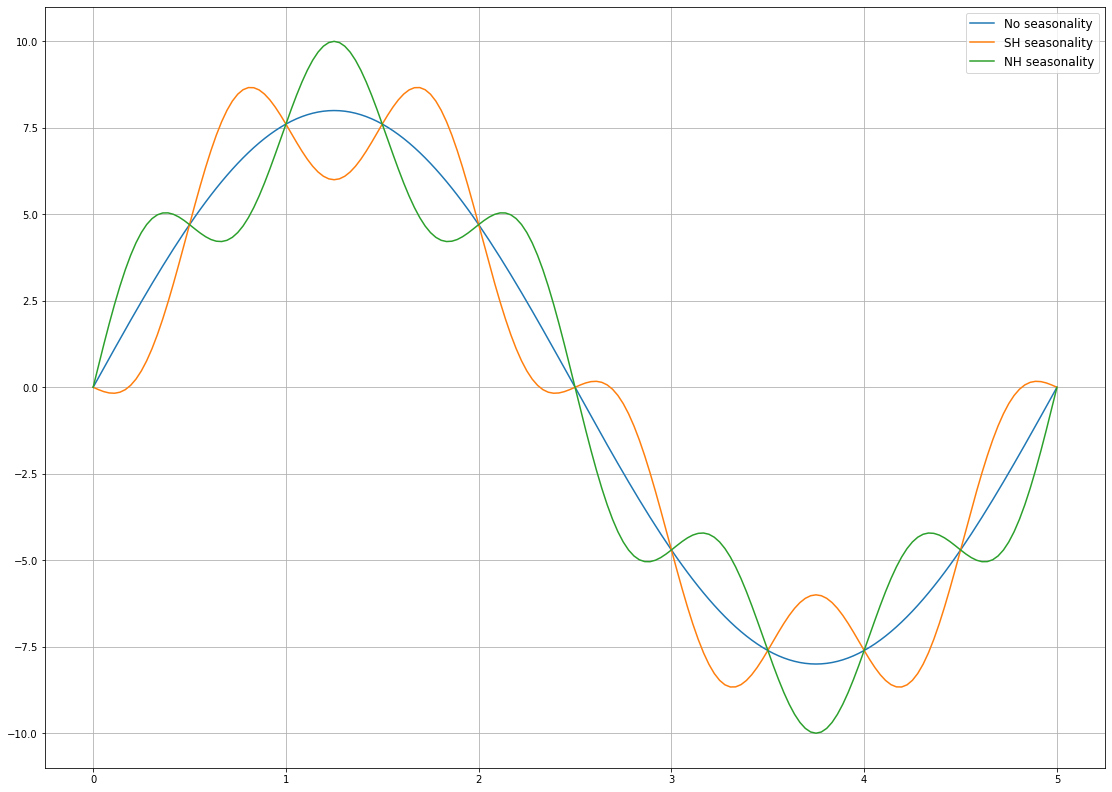

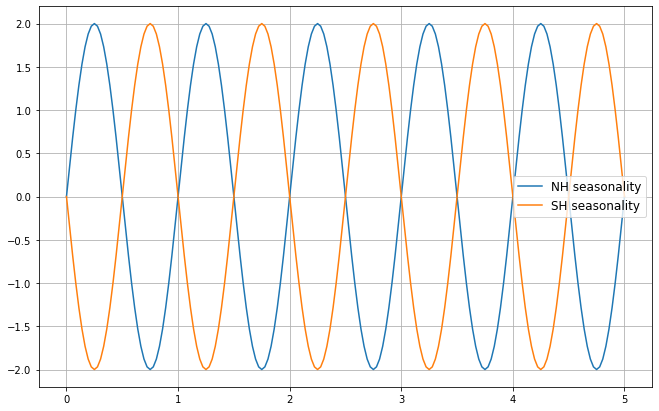

In [21]:
plt.figure(figsize=(19,14))
year = 5
plt.plot((t/360)[:year*36+1], sin(8.0, 5)[:year*36+1],label='No seasonality')
plt.plot((t/360)[:year*36+1], (sin(8.0, 5)+Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.plot((t/360)[:year*36+1], (sin(8.0, 5)+Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')

plt.legend()
plt.grid()
plt.legend(fontsize=12)

plt.figure(figsize=(11,7))
plt.plot((t/360)[:year*36+1], (Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

In [27]:
plt.figure(figsize=(13,9))
plt.plot(Q_period5+Q_season_SH)
plt.plot(Q_season_SH)
plt.grid()

ValueError: operands could not be broadcast together with shapes (3601,) (180001,) 

<Figure size 936x648 with 0 Axes>

### Run sinusoidal forcing with and without seasonality (SH and NH)

In [28]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

period = 1
Q_season_SH = 32 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
T0_season_SH = 4 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
Q_season_NH = 32 * np.sin((2 * np.pi / (period * 360)) * t)
T0_season_NH = 4 * np.sin((2 * np.pi / (period * 360)) * t)

period = 5
Q_period5 = sin(8.0, period)
T0_period5 = sin(1.0, period)

T_period5_without_seasonal = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_period5, T0_period5, years)
T_period5_with_seasonal_SH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, control_with_seasonal_SH[:,-1], Q_period5+Q_season_SH, T0_period5+T0_season_SH, years)
T_period5_with_seasonal_NH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, control_with_seasonal_NH[:,-1], Q_period5+Q_season_NH, T0_period5+T0_season_NH, years)

In [39]:
periodic_noseason = average_over_period(OHC(T_period5_without_seasonal), 8)
periodic_SH = average_over_period(OHC(T_period5_with_seasonal_SH), 8)
periodic_NH = average_over_period(OHC(T_period5_with_seasonal_NH), 8)

Text(0.5, 0, 'Years')

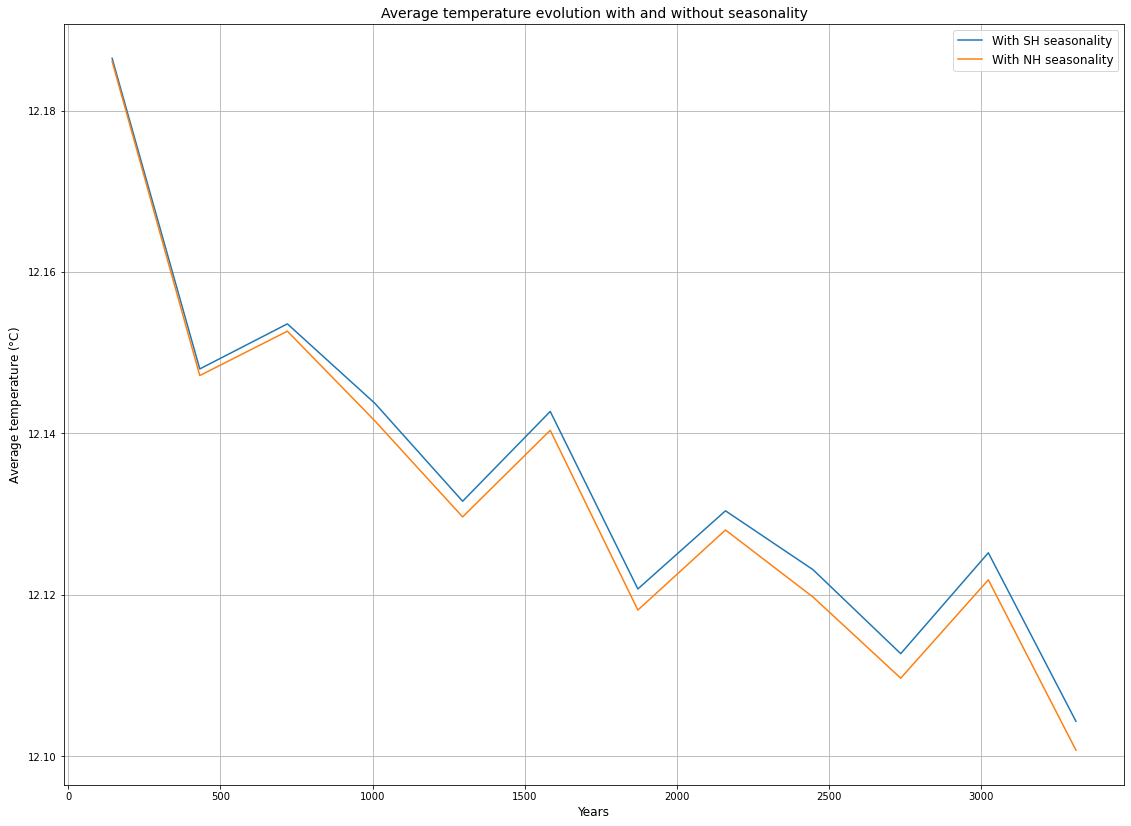

In [41]:
plt.figure(figsize=(19,14))
# plt.plot(periodic_noseason[1], periodic_noseason[0], label='No seasonality')
plt.plot(periodic_SH[1], periodic_SH[0], label='With SH seasonality')
plt.plot(periodic_NH[1], periodic_NH[0],label='With NH seasonality')
plt.grid()
plt.legend(fontsize=12)
plt.title('Average temperature evolution with and without seasonality',fontsize=14)
plt.ylabel('Average temperature ($\degree$C)',fontsize=12)
plt.xlabel('Years',fontsize=12)

In [40]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

period = 1
Q_season_SH = 2.0 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
T0_season_SH = 0.25 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
Q_season_NH = 2.0 * np.sin((2 * np.pi / (period * 360)) * t)
T0_season_NH = 0.25 * np.sin((2 * np.pi / (period * 360)) * t)

period = 10
Q_period10 = sin(8.0, period)
T0_period10 = sin(1.0, period)

T_period10_without_seasonal = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_period10, T0_period10, years)
T_period10_with_seasonal_SH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, control_with_seasonal_SH[:,-1], Q_period10+Q_season_SH, T0_period10+T0_season_SH, years)
T_period10_with_seasonal_NH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, control_with_seasonal_NH[:,-1], Q_period10+Q_season_NH, T0_period10+T0_season_NH, years)

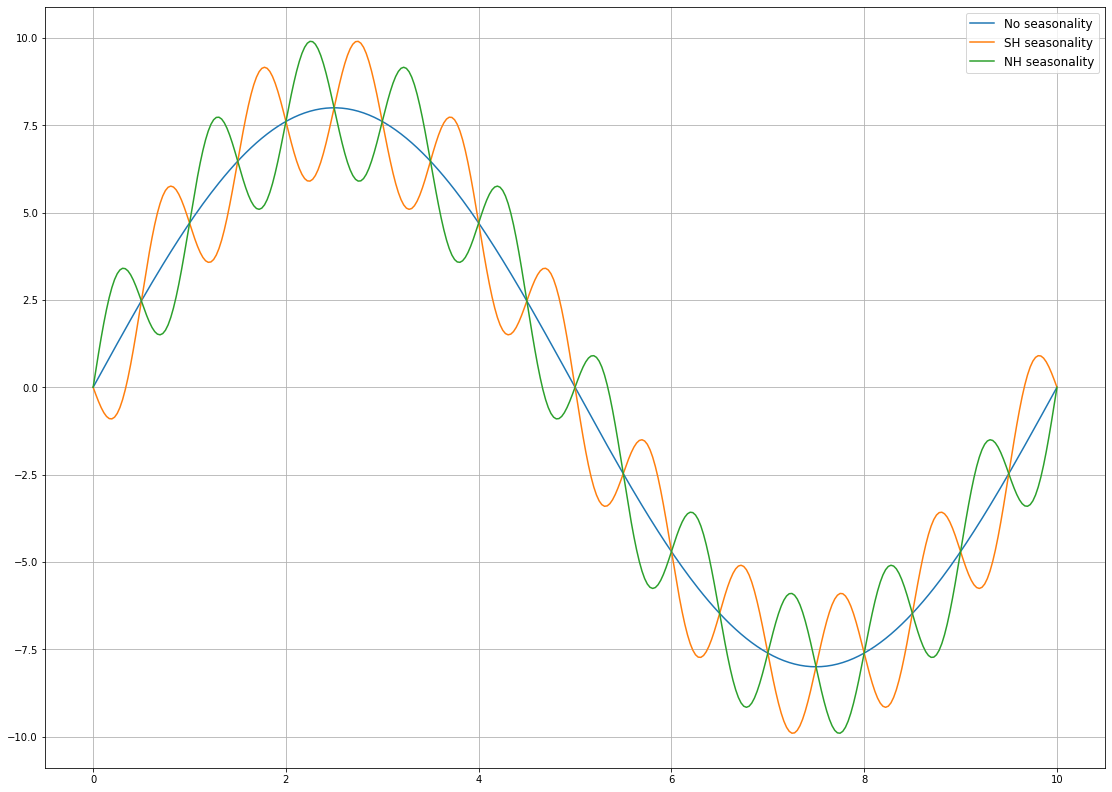

In [42]:
plt.figure(figsize=(19,14))
year = 10
plt.plot((t/360)[:year*36+1], sin(8.0, 10)[:year*36+1],label='No seasonality')
plt.plot((t/360)[:year*36+1], (sin(8.0, 10)+Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.plot((t/360)[:year*36+1], (sin(8.0, 10)+Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')

plt.legend()
plt.grid()
plt.legend(fontsize=12)

Text(0.5, 0, 'Years')

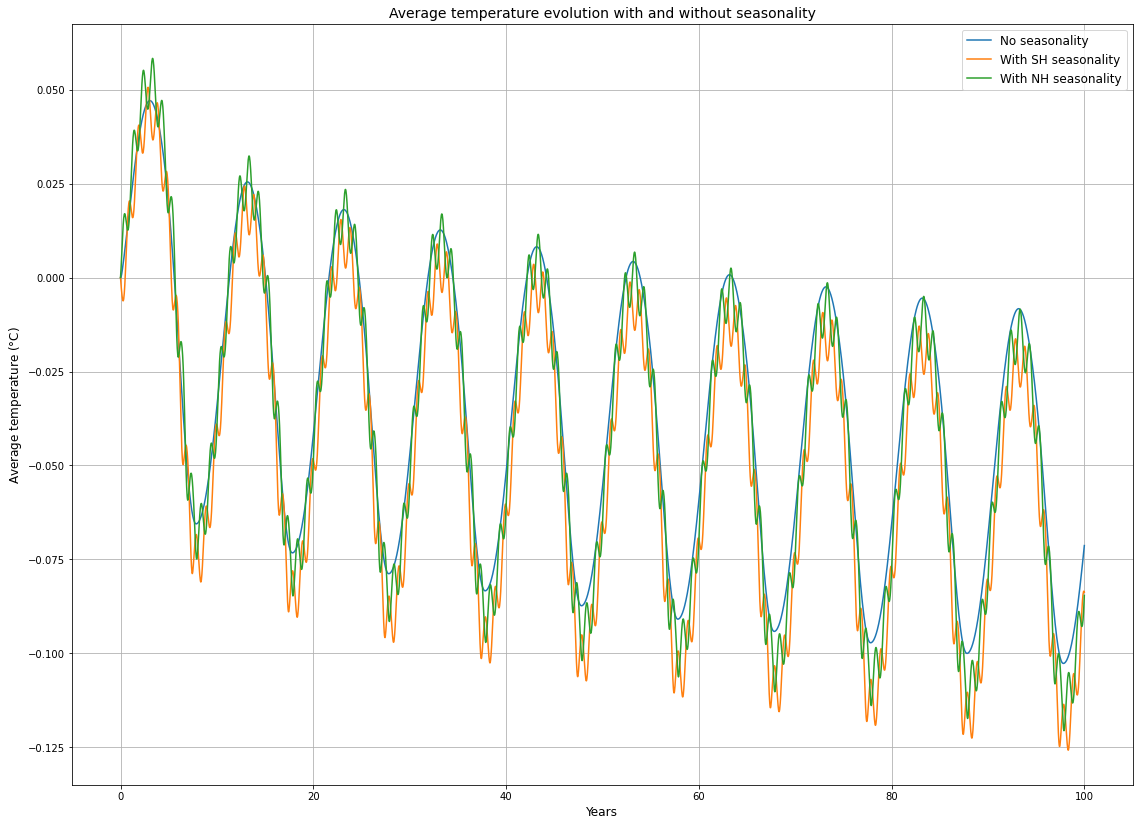

In [41]:
plt.figure(figsize=(19,14))
plt.plot(t/360, OHC(T_period10_without_seasonal) - OHC(T_period10_without_seasonal)[0],label='No seasonality')
plt.plot(t/360, OHC(T_period10_with_seasonal_SH) - OHC(T_period10_with_seasonal_SH)[0],label='With SH seasonality') # - OHC(T_period5_with_season_SH)[0] + (OHC(T_period5_with_season_NH)[0] + OHC(T_period5_with_season_SH)[0])/2
plt.plot(t/360, OHC(T_period10_with_seasonal_NH) - OHC(T_period10_with_seasonal_NH)[0],label='With NH seasonality') # - OHC(T_period5_with_season_NH)[0] + (OHC(T_period5_with_season_NH)[0] + OHC(T_period5_with_season_SH)[0])/2
plt.grid()
plt.legend(fontsize=12)
plt.title('Average temperature evolution with and without seasonality',fontsize=14)
plt.ylabel('Average temperature ($\degree$C)',fontsize=12)
plt.xlabel('Years',fontsize=12)

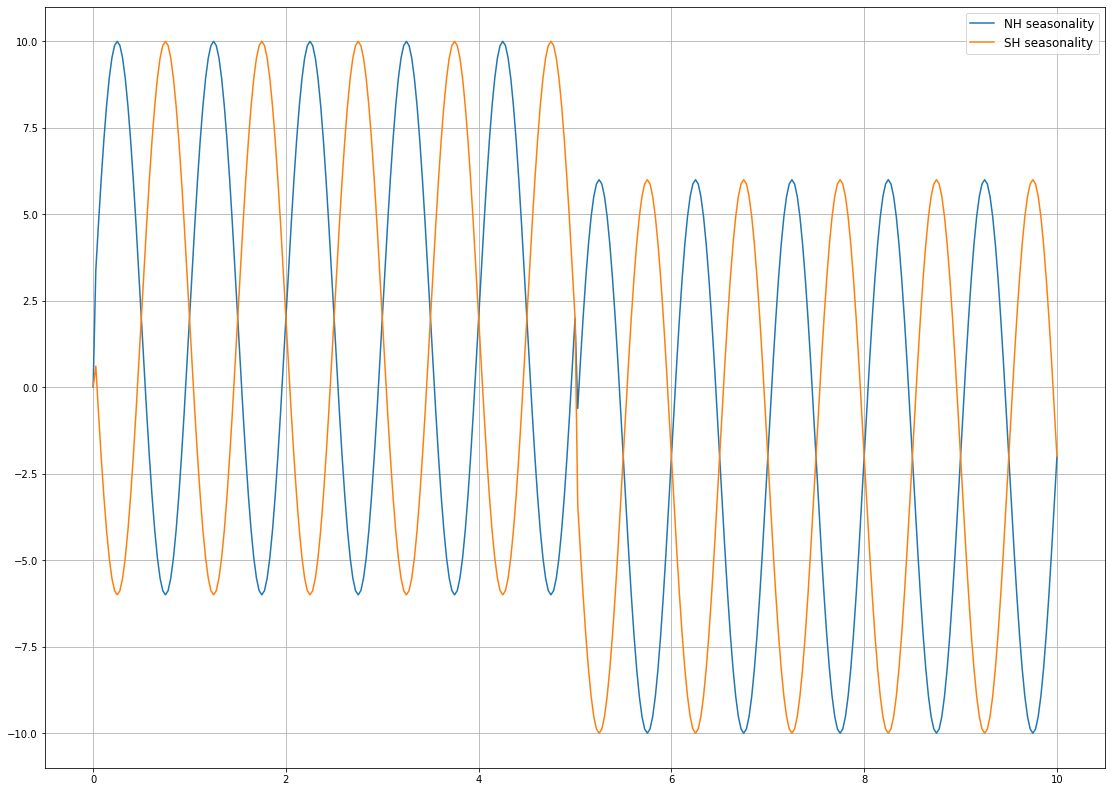

In [51]:
plt.figure(figsize=(19,14))
year = 10
Q_season_NH_10 = 8.0 * np.sin((2 * np.pi / (1 * 360)) * t)
Q_season_SH_10 = 8.0 * np.sin((2 * np.pi / (1 * 360)) * (t - 360/2))
Q_10 = 2.0*np.sign(sin(8.0, 10))
plt.plot((t/360)[:year*36+1], (Q_10+Q_season_NH_10)[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (Q_10+Q_season_SH_10)[:year*36+1],label='SH seasonality')
#plt.plot((t/360)[:year*36+1], Q_10[:year*36+1],label='No seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)